# Convolutional Neural Network
**Due: Mondy, 11/28/2022, 2:15 PM**

Welcome to your seventh assignment. You will build and train a convolutional neural network using ([PyTorch](https://pytorch.org/)).

Contents:

1. (80%) Exercise 2: Create Convolutional Neural Network Model
2. (20%) Exercise 3: Training Iterations

Instructions:

- The code between the ### START CODE HERE ### and ### END CODE HERE ### comments will be graded.
- **Change variable names at your own risk. Make sure you understand what you are doing.**

**You will learn:**
- Create convolutional neural network models.
- Calculate size for convolution layers.


## Import Libraries
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.

**If you installed [PyTorch]((https://pytorch.org/get-started/locally/)) using Conda, you may want to [switch Python interpreter](https://code.visualstudio.com/docs/python/environments) to comply with the Conda environment that hosts PyTorch.**

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Resize
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\willw\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 - Load Dateset
#### Load CIFAR10 Dataset
Load CIFAR10 dataset from TorchVision datasets. 


Files already downloaded and verified
Files already downloaded and verified
number of training examples: 50000
training image resolution (CHANNEL, HEIGHT, WIDTH): torch.Size([3, 32, 32])
number of test examples: 10000
test image resolution (CHANNEL, HEIGHT, WIDTH): torch.Size([3, 32, 32])


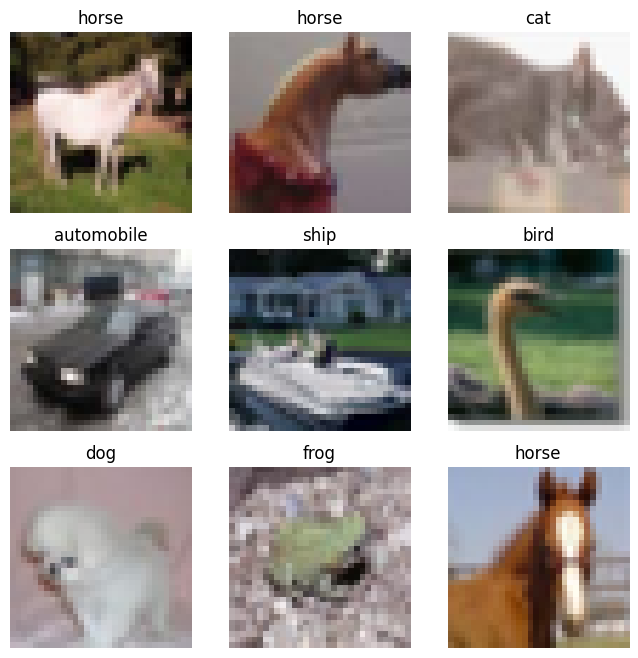

In [2]:
# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
)
# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)


# Investigate datasets
num_train = len(training_data)
res_train = training_data[0][0].shape
num_test = len(test_data)
res_test = test_data[0][0].shape

print(f"number of training examples: {num_train}")
print(f"training image resolution (CHANNEL, HEIGHT, WIDTH): {res_train}")
print(f"number of test examples: {num_test}")
print(f"test image resolution (CHANNEL, HEIGHT, WIDTH): {res_test}")
# print(training_data[0])  # debug


# Visulization
labels_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img = torch.permute(img, (1, 2, 0))  # you may want to permute order of the axes
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")


--------------


## 2 - Build the Model
#### **(80%) Exercise 2**: Create Convolutional Neural Network Model
Define a neural network model class from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). .
- Define the layers of the model in `__init__` function.
- Define how data will pass through the model in the `forward` function. 
- (Optional) Move the operations to GPU if available.

**Hint:** 
1. you may find [Neural Networks Tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) helpful.
2. To calculate convolution and pooling layer size, you may want to refer to [this blog](https://dingyan89.medium.com/calculating-parameters-of-convolutional-and-fully-connected-layers-with-keras-186590df36c6)


In [19]:
# device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
    ### START CODE HERE ###
        # these lines just define the parameters and output of each nn layer
        self.conv1 = nn.Conv2d(3, 48, 3) # (color channel size, output channel size, kernel size (5x5))
        self.pool = nn.MaxPool2d(2, 2) # (output size of 2, stride size of 2)
        self.conv2 = nn.Conv2d(48, 192, 2) # (input size same as conv1 output, output size conv2, kernel (5x5))
        self.conv3 = nn.Conv2d(192, 128, 2)
        self.fc1 = nn.Linear(128*3*3, 120) # 16*5*5 is the flattened output size of the output image from last pooling layer (after conv2)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 is for 10 classes

    def forward(self, x): # this defines the order that layers are executed
        x = self.pool(F.relu(self.conv1(x))) # conv1 --> relu activation --> pool
        x = self.pool(F.relu(self.conv2(x))) # conv2 --> relu activation --> pool
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flattens tensor, except the batch dimension
        x = F.relu(self.fc1(x)) # fc1 --> relu activation
        x = F.relu(self.fc2(x)) # fc2 --> relu activation
        x = self.fc3(x) # no activation function here
        return x

    ### END CODE HERE ###

# Sanity check
model = ConvNet().to(device)  # you may want to include variables to specify model structure
# print(model)
X = torch.rand(1, 3, 32, 32, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class probability: {pred_probab}")
print(f"Predicted class: {y_pred}: {labels_map[int(y_pred)]}")



Using cuda device
Predicted class probability: tensor([[0.0900, 0.1095, 0.1035, 0.1028, 0.1014, 0.1007, 0.0903, 0.0940, 0.0967,
         0.1112]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([9], device='cuda:0'): truck


> **Expected:**
```console
Predicted class probability: tensor([[0.0995, 0.0981, 0.0977, 0.1089, 0.0962, 0.1006, 0.1000, 0.1005, 0.1043,
         0.0943]], grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([3]): cat
```

--------------


## 3- Optimize the Model Parameters

#### **(20%) Exercise 3**: Training Iterations
The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. Log the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.

To start a training process:
- initialize neural network model with your choice of architecture of convolutional layers.
- Pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over the dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. 
- Create a `DataLoader` for `training_data` with your choice of batch size.
- Create a `DataLoader` for `test_data` with your choice of batch size.
- define a loss function.
- define an optimizer.
- Specify training epochs.


Epoch 1
-------------------------------
loss: 2.305980  [    0/50000]
loss: 1.921134  [10000/50000]
loss: 1.861187  [20000/50000]
loss: 1.552785  [30000/50000]
loss: 1.288184  [40000/50000]
Test Error: 
 Accuracy: 48.6%, Avg loss: 1.420001 

Epoch 2
-------------------------------
loss: 1.460045  [    0/50000]
loss: 1.369113  [10000/50000]
loss: 1.528873  [20000/50000]
loss: 1.334292  [30000/50000]
loss: 1.130696  [40000/50000]
Test Error: 
 Accuracy: 55.8%, Avg loss: 1.241942 

Epoch 3
-------------------------------
loss: 1.272568  [    0/50000]
loss: 1.098021  [10000/50000]
loss: 1.325038  [20000/50000]
loss: 1.255996  [30000/50000]
loss: 0.967851  [40000/50000]
Test Error: 
 Accuracy: 60.0%, Avg loss: 1.125329 

Epoch 4
-------------------------------
loss: 1.112446  [    0/50000]
loss: 0.957474  [10000/50000]
loss: 1.178418  [20000/50000]
loss: 1.124758  [30000/50000]
loss: 0.845592  [40000/50000]
Test Error: 
 Accuracy: 64.2%, Avg loss: 1.026347 

Epoch 5
------------------------

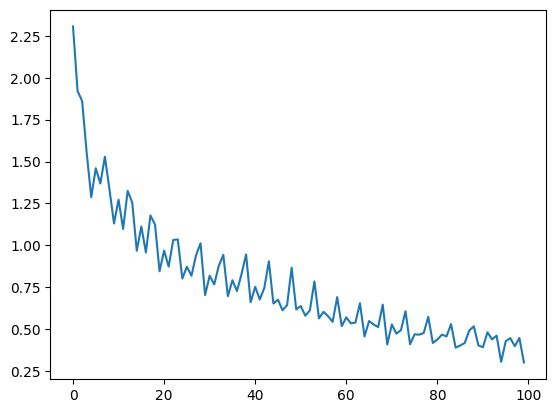

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_losses.append(loss)
    return train_losses

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    accuracy /= size
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")


### END CODE HERE ###
cifar_model = ConvNet().to(device)
train_dataloader = DataLoader(training_data, batch_size=100)
test_dataloader = DataLoader(test_data, batch_size=1000)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cifar_model.parameters(), lr= 0.001) 
epochs = 20
### START CODE HERE ###

sum_train_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses = train(train_dataloader, cifar_model, loss_fn, optimizer)
    sum_train_losses += train_losses
    test(test_dataloader, cifar_model, loss_fn)
print("Done!")
# Plot train losses
plt.plot(sum_train_losses)
plt.show()


--------------


## 4 - Evaluation

#### Test Image from Test Dataset
This model can now be used to make predictions. You can change the index of the test example from `test_data` in the following block. 


Predicted: "horse", Actual: "horse"


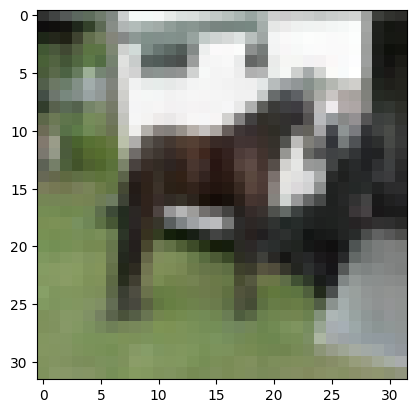

In [21]:
cifar_model.eval()
x, y = test_data[20][0], test_data[20][1]
x = x.unsqueeze(dim=0)
with torch.no_grad():
    pred = cifar_model(x.to(device))
    predicted, actual = labels_map[int(pred[0].argmax(0))], labels_map[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
plt.imshow(x.squeeze().permute(1, 2, 0), cmap="gray")


#### Test Custom Images
Upload custom pictures to the `images/` directory, one picture for each class. Evaluate and observe the predicted results with the trained model and newly uploaded pictures.   


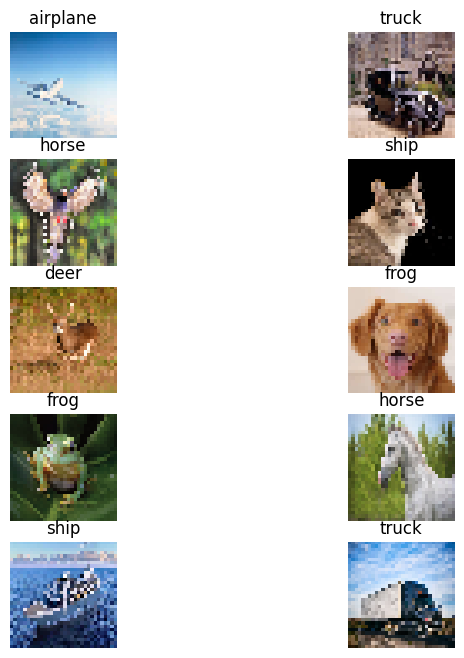

In [22]:
# figure = plt.figure(figsize=(8, 8))
figure = plt.figure(figsize=(8,8))
cols, rows = 2, 5
resize = Resize((32, 32))
for i in range(1, cols * rows + 1):
    # sample_idx = torch.randint(len(training_data), size=(1,)).item()
    # img, label = training_data[sample_idx]
    img = resize(read_image('images/'+labels_map[i-1]+'.jpg')) / 255.
    img = img.unsqueeze(dim=0)
    pred = cifar_model(img.to(device))
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[int(pred[0].argmax(0))])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0), cmap="gray")
